In [1]:
# Install required packaged (only need to be done once after each restart of the jupyter server)
!pip install -q pandas matplotlib seaborn numpyro==0.14.0 jax==0.4.26 jaxlib==0.4.26 arviz statsmodels

In [1]:
# Import all required packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interactive

from numpyro.diagnostics import hpdi
from jax import random, vmap
import jax.numpy as jnp

import arviz as az
import jax 
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
%matplotlib inline

In [2]:
# Set random number seeds for reproducibility
rng_key = random.PRNGKey(0)
np.random.seed(0)

# Notebook 01 - Example of a complete Probabilistic Workflow

## Aims of the notebook

__Content wise aim__
- Illustrate the complete PP workflow with a simple example 

__Coding/technical aim__
- Intro to Jupyter Notebooks / JupyterHub
- Intro to Python/NumPyro coding


## Data-Generating-Process (DGP) centric modelling workflow

![test](../img/pp_workflow.png)

Source: Storm, H., Heckelei, T., & Baylis, K. (2024). Probabilistic programming for embedding theory and quantifying uncertainty in econometric analysis. European Review of Agricultural Economics, 51(3), 589-616. https://doi.org/10.1093/erae/jbae016;      .


## Preperation activity: Winter wheat yield in tonnes per region (in T/ha)

***
<div class="alert alert-block alert-success">

__Group Task: Do a quick search on your phone and discuss with your neighbor__

What is the...
- most likely value : 8 ton/ha in an average region
- most negative value that you believe could happen: 5 ton/ha
- most positive value that you believe could happen: 10 ton/ha

... for Winter wheat yield in tonnes per region (in T/ha)

</div>

    


In [3]:
# Collect all the results from all groups, one row per group
lstStudents = [
   #[min,mostLikely,max]
   #[.. , .., ..], # Add values here
[0,7,12],
    [3.5,7.5,10],
    [4,6.5,8.5],
    [2,6,8],
]
dfGuess = pd.DataFrame(lstStudents,columns=['min','mostLikely','max'])

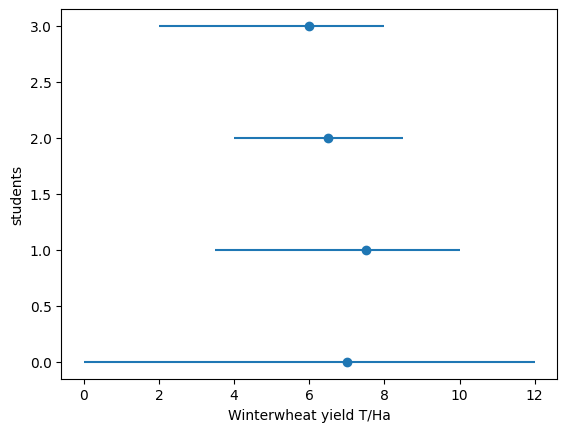

In [4]:
fig,ax = plt.subplots()
ax.errorbar(dfGuess['mostLikely'],dfGuess.index, 
            xerr=[dfGuess['mostLikely']-dfGuess['min'],dfGuess['max']-dfGuess['mostLikely']], 
            fmt='o')
ax.set_xlabel('Winterwheat yield T/Ha');
ax.set_ylabel('students');

## Fit a normal to expecations

***
<div class="alert alert-block alert-success">

__Class Task: Let's try to find a normal distribution that fits the range of all the yield guesses__

Use the interactive widget below to find a fitting mean and std that would fit to our expectations
</div>


In [ ]:
# Approximate guess with a normal distribution
def plotHist(meanYield=dfGuess['mostLikely'].mean(), stdYield=10):
    numSamples = 5000
    fig,ax = plt.subplots()
    sns.histplot(data=np.random.normal(meanYield,stdYield,numSamples),legend=False,ax=ax, kde=True, bins=50);
    ax.set_xlabel('Yield [t/ha]')
    plt.show()

interactive_plot = interactive(plotHist, meanYield=(0, 15.0,0.1), stdYield=(0, 10, 0.1))
output = interactive_plot.children[-1]
interactive_plot



interactive(children=(FloatSlider(value=6.75, description='meanYield', max=15.0), FloatSlider(value=10.0, desc…

***
<div class="alert alert-block alert-success">

__Task: Enter the mean and std below such that we can use to below__

</div>

In [7]:
# Conclusion when assuming that yield is Normally distributed 
# 1) Mean of 
guessMeanYield =  7.7 
# 2) standard deviation of: 
guessStdYield =   2.4
# are reasonable values

## Vote on prior regression lines

***
<div class="alert alert-block alert-success">

__Class Task: Let's vote on which regression lines we find plausible__

Use the interactive widget below to randomly generate regression lines and vote with regression lines we find plausible</div>


In [8]:
%matplotlib inline
# Define widget elements
buttonAccept = widgets.Button(
    description='Plausible',
    button_style='success', 
)
buttonRecect =widgets.Button(
    description='Implausible',
    button_style='danger', 
)
betaProposalField = widgets.FloatText(
    value=np.random.normal(loc=0.0, scale=.1, size=1),
    description='Beta Proposal:',
    disabled=True
)
output = widgets.Output()

# Define empty list for beta coefficients
betaList = []

# Function to plot one regression line
def plotRegLine(ax,x,beta,avgY,avgX,color='lightgray'):
    y = (x-avgX)*beta+avgY
    ax.plot(x,y,color=color)  

# Function to plot all regression lines for all betas in betaList and 
# optionally one proposal
def plotList_Proposal(betaList,betaProposal=None):
    fig,ax = plt.subplots()
    ax.set_ylim(0,15)
    ax.set_xlim(0,100)
    ax.axhline(y=guessMeanYield, color='lightgray', linestyle='--')
    ax.set_ylabel('Winterwheat yield T/Ha')
    ax.set_xlabel('Soil number (Bodenzahl)')
    avgX = 50
    soil = np.arange(0,100,2)

    # Plot existing list
    for beta in betaList:    
        plotRegLine(ax,soil,beta,guessMeanYield,avgX)
    
    # Plot proposal beta
    if betaProposal is not None: 
        plotRegLine(ax,soil,betaProposal,guessMeanYield,avgX, color='red')
    
    plt.show()

# Function for widget interactions
def on_button_accept(b):
    # Append proposal to list
    betaList.append(betaProposalField.value)
    # Make new proposal
    betaProposal = np.random.normal(loc=0.0, scale=.1, size=1)
    betaProposalField.value = betaProposal
    output.clear_output()
    with output:
        plotList_Proposal(betaList,betaProposal)
def on_button_reject(b):
    betaProposal = np.random.normal(loc=0.0, scale=.1, size=1)
    betaProposalField.value = betaProposal
    output.clear_output()
    with output:
        plotList_Proposal(betaList,betaProposal)

# Show plot with one line on start
with output:
    betaProposal = np.random.normal(loc=0.0, scale=.1, size=1)
    plotList_Proposal(betaList,betaProposal)

buttonAccept.on_click(on_button_accept)
buttonRecect.on_click(on_button_reject)
widgets.VBox([widgets.HBox([buttonAccept, buttonRecect,betaProposalField]), output])

In [ ]:
# by approving plausible and implausibe lines, we derive a plot with various possible lines and the consequential meanings.
#Important is that we think about we think about the theoretical knowledge behind our decision to approve plausibility and implausibility


In [ ]:
# Save betaList
pd.DataFrame(betaList,columns=['betaAccepted']).to_csv("../data/lecture02_betaList_Dami.csv")
plotList_Proposal(betaList)

# Workflow Step 1: Quantity to estimate

__Define the research question to answer:__

    What is the effect of soil quality on winter wheat yield?

__Hypothesis__

    Soil quality has a positive effect on yield

# Workflow Step 2: Scientific Model

__How do we imagine the world to work?__

Many possible model choices

- Linear model
- Non-linear models (e.g. some flexible machine learning models)
- Agronomic crop growth models (see for example [Paola et al. 2016](https://doi.org/10.1002/jsfa.7359    ) for a review of existing models)

Linear model: 
- Assume that there is a linear relationship between soil quality and yield

# Workflow Step 3: Statistical Model

### We will consider a Linear model as the data-generating process

$y_i \sim Normal(x_i \beta, \sigma)$ # y is normally distributed given xB and sigma

$\beta \sim Normal(0,a)$ # beta (reg coef) is normally distributed with the mean of 0 and std = a

$\sigma \sim Exponential(b)$ # sigma cannot be negative that is why we use exponential

__With:__

$y_i$ standardized yield per field $i$

$x_i$ standardized soil quality points (*in German "Bodenpunkte"*)

__Define our hypothesis in terms of the statistical model__

H1: $\beta > 0$


In [10]:
#Basically above, we state a statistical model highlighting the distribution of the data in our scientific model. Next, we transfer this into
#code in step 4

In [10]:
# Illustrate normal distributions
def plotNormalHist(mean=0, std=1):
    numSamples = 10000
    fig,ax = plt.subplots()
    sns.histplot(data=np.random.normal(mean,std,numSamples),legend=False,ax=ax,bins=50);
    plt.show()

interactive_plot = interactive(plotNormalHist, mean=(-20, 20, 1), std=(0, 10, 0.1))
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(IntSlider(value=0, description='mean', max=20, min=-20), FloatSlider(value=1.0, descript…

In [16]:
# Illustrate exponential distributions

# Note Numpyro uses the rate in the Exponential while numpy uses the scale=1/rate
# numpyro.distributions.Exponential(rate)
# np.random.exponential(1/rate)

def plotExponentialHist(lam=1):
    numSamples = 10000
    fig,ax = plt.subplots()
    #sns.histplot(data=np.random.exponential(lam,numSamples),legend=False,ax=ax,bins=50);
    with numpyro.handlers.seed(rng_seed=909):
        outcome = numpyro.sample("height", dist.Exponential(lam).expand([numSamples]))
    sns.histplot(data=outcome,legend=False,ax=ax,bins=50);
    plt.show()

interactive_plot = interactive(plotExponentialHist, lam=(0, 5,0.1))
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(FloatSlider(value=1.0, description='lam', max=5.0), Output()), _dom_classes=('widget-int…

# Workflow Step 4: Synthetic Data

1) Implement the statistical model in code
2) Generate synthetic data using the model
3) Check if the generated data matches the existing domain knowledge
4) Adjust scientific model, statistical mode, or code until it matches domain knowledge 

1) Implement the statistical model in code

In [18]:
def ourYieldModel(Soil_sd, a=1, b=1, Yield=None):
    beta = numpyro.sample('beta', dist.Normal(0,a))
    sigma = numpyro.sample('sigma', dist.Exponential(b))
    numpyro.sample('Yield_sd',dist.Normal(Soil_sd*beta,sigma), obs=Yield)

In [2]:
#Q: what is the difference between 'Yield_sd', Yield=None and obs=Yield
'''
1. `Yield=None` sets `Yield` as an optional parameter of the `ourYieldModel` function.
If you pass a value for `Yield` when calling `ourYieldModel`, it will override the default `None` value. 
When `Yield=None`, it indicates that no observed data has been provided, so the model will perform
**prior predictive sampling** (sampling from the prior without conditioning on observed data).
If `Yield` is given (i.e., not `None`), the model will condition on the observed data, enabling posterior inference.

2. The `obs` argument in `numpyro.sample` specifies the observed data that we want to condition on.
When `obs=Yield` is set, `NumPyro` treats the `Yield_sd` distribution as an observed variable
and conditions the model on this data. i.e., the posterior distribution is calculated based on the likelihood of the observed data (obs).

- `Yield=None` allows the function to be used for both prior predictive and posterior sampling.
- `obs=Yield` tells `NumPyro` to use `Yield` as observed data when it is available.

'''

'\n1. `Yield=None` sets `Yield` as an optional parameter of the `ourYieldModel` function.\nIf you pass a value for `Yield` when calling `ourYieldModel`, it will override the default `None` value. \nWhen `Yield=None`, it indicates that no observed data has been provided, so the model will perform\n**prior predictive sampling** (sampling from the prior without conditioning on observed data).\nIf `Yield` is given (i.e., not `None`), the model will condition on the observed data, enabling posterior inference.\n\n2. The `obs` argument in `numpyro.sample` specifies the observed data that we want to condition on.\nWhen `obs=Yield` is set, `NumPyro` treats the `Yield_sd` distribution as an observed variable\nand conditions the model on this data. i.e., the posterior distribution is calculated based on the likelihood of the observed data (obs).\n\n- `Yield=None` allows the function to be used for both prior predictive and posterior sampling.\n- `obs=Yield` tells `NumPyro` to use `Yield` as obse

2. Generate synthetic data using the model

In [20]:
# Define number of regions
numRegions = 50  # shape

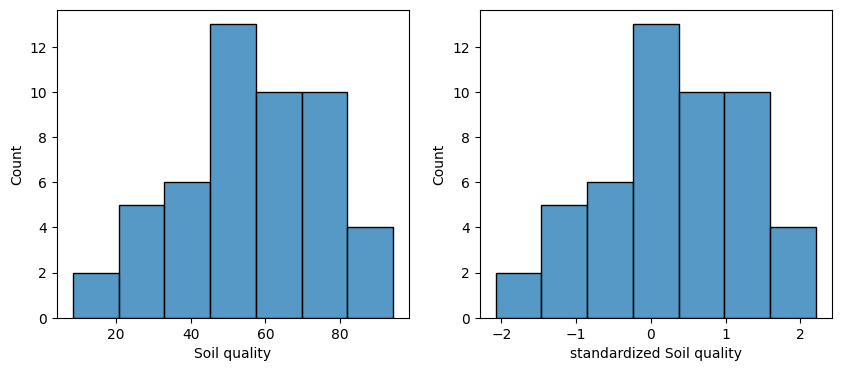

In [21]:
# Generate synthetic soil data
meanSoilSynthetic = 50
stdSoilSynthetic = 20
soil_synthetic = np.random.normal(meanSoilSynthetic,stdSoilSynthetic,numRegions)

# Standardize soil data
soil_sd_synthetic = (soil_synthetic-meanSoilSynthetic)/stdSoilSynthetic

# Plot soil histograms
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.histplot(data=soil_synthetic,legend=False,ax=ax1);
sns.histplot(data=soil_sd_synthetic,legend=False,ax=ax2);
ax1.set_xlabel('Soil quality')
ax2.set_xlabel('standardized Soil quality');


In [22]:
# Generate synthetic data from model
nPriorSamples = 10 # number of prior samples

# Update the random number seed
rng_key, rng_key_ = random.split(rng_key) 

a=3
b=3

# Draw sample from model
prior_predictive = Predictive(ourYieldModel, num_samples=nPriorSamples)
prior_samples = prior_predictive(rng_key_,Soil_sd=soil_sd_synthetic,a=a, b=b)

__Unpack NumPyro ```Predictive()```__ 

beta: -0.8198551907948158
sigma: 1.4239576655691597


Yield_sd: [-1.45515911 -2.81856783  1.83606285 -1.86904031  1.3104015   0.34148769
 -0.14517421 -2.40785065 -1.42499461  2.71546666  2.02140084  2.49531528
 -0.68086764  2.26998154 -1.66771101  0.93426676 -0.3557071  -1.82169853
  1.26890763  0.00521032  0.36928787  0.53034604  0.3273018  -0.89437631
 -4.33883013  0.8195398  -2.39240344 -2.41530957 -2.21653355  1.61853999
 -0.37098148  2.76132133 -2.25979301 -1.61120679 -1.71667131 -1.6087102
 -0.02041408  0.3771863  -4.54592018 -0.20213586  1.67284897 -0.95796893
 -2.62862809 -0.53720273  0.78581809 -0.42481945  1.21762961 -0.17464702
 -0.25674479  1.86637213]


Text(0.5, 0, 'Yield [t/ha]')

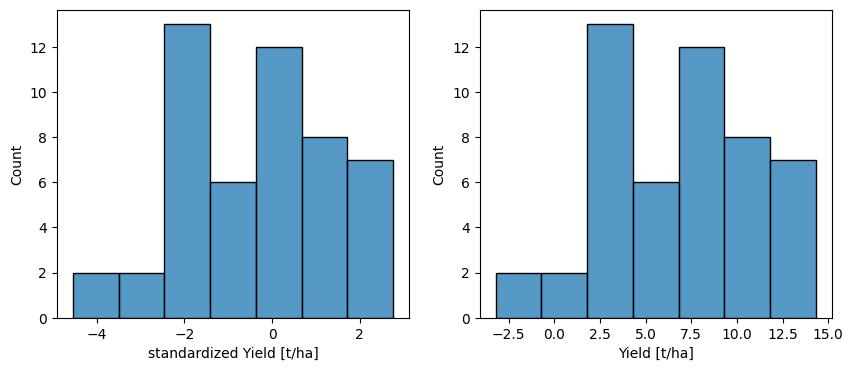

In [23]:
# What happens in:
# prior_predictive = Predictive(ourYieldModel, num_samples=nPriorSamples)
# prior_samples = prior_predictive(rng_key_,Soil=soilSynthetic)

# 1) Sample beta from ~Normal(0,a)
a = 1
beta = np.random.normal(0,a)
print('beta:',beta)
# 2) Sample sigma from ~Exponential(b)
b = 1
sigma = np.random.exponential(b)
print('sigma:',sigma)
# 3) Sample Yield from ~Normal(Soil*beta,sigma)
Soil_sd = soil_sd_synthetic
Yield_sd = np.random.normal(Soil_sd*beta,sigma) 
print('\n')
print('Yield_sd:',Yield_sd)

# Predictive() does these steps "num_samples" times

# Plot generated data
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.histplot(data=Yield_sd,legend=False,ax=ax1);
sns.histplot(data=Yield_sd*guessStdYield+guessMeanYield,legend=False,ax=ax2);
ax1.set_xlabel('standardized Yield [t/ha]')
ax2.set_xlabel('Yield [t/ha]')



In [24]:
# Check what is in prior_samples
print('Keys of dict',prior_samples.keys())
print('\n')
print('Size of Yield_sd',prior_samples['Yield_sd'].shape)
print('Size of beta',prior_samples['beta'].shape)
print('Size of sigma',prior_samples['sigma'].shape)
print('\n')
print('beta:',prior_samples['beta'])
print('\n')
print('sigma:',prior_samples['sigma'])

Keys of dict dict_keys(['Yield_sd', 'beta', 'sigma'])


Size of Yield_sd (10, 50)
Size of beta (10,)
Size of sigma (10,)


beta: [ 4.025384   -1.4731394  -2.5148184   4.7323513  -4.009799   -3.4316275
 -1.510345   -0.81065285 -0.5537076   1.324746  ]


sigma: [0.6537336  0.5019915  0.19574133 0.03080535 0.05710463 0.24177901
 0.9952439  0.4901538  0.10881802 0.00443709]


3) Check if the generated data matches the existing domain knowledge

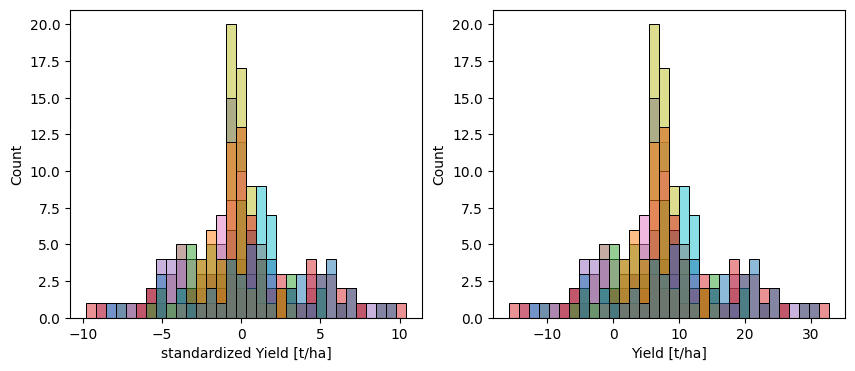

In [25]:
# Plot generated data
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10, 4))
sns.histplot(data=prior_samples['Yield_sd'].T,legend=False,ax=ax1);
sns.histplot(data=prior_samples['Yield_sd'].T*guessStdYield+guessMeanYield,legend=False,ax=ax2);
ax1.set_xlabel('standardized Yield [t/ha]')
ax2.set_xlabel('Yield [t/ha]');


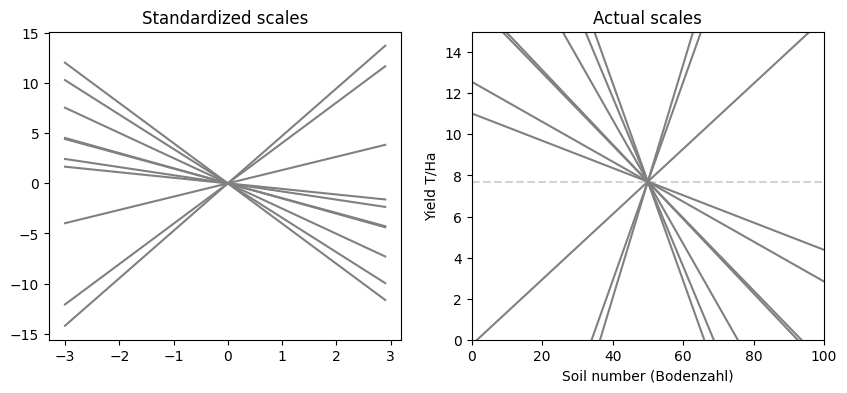

In [26]:
# Define a function to plot regression lines
def plot_regression_lines(samples,meanYield,stdYield,meanSoil,stdSoil,nLines = None):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
    ax2.set_ylim(0,15)
    ax2.axhline(y=meanYield, color='lightgray', linestyle='--')
    ax2.set_ylabel('Yield T/Ha')
    ax2.set_xlabel('Soil number (Bodenzahl)')
    avgX = 50
    #soil_range = np.arange(0,100,1)
    #soil_sd_range = (soil_range-meanSoil)/stdSoil
    soil_sd_range = np.arange(-3,3,0.1)
    soil_range = soil_sd_range*stdSoil+meanSoil

    ax2.set_xlim(np.max([0,np.min(soil_range)]),np.min([100,np.max(soil_range)]))
    
    if nLines is None:
        nLines = samples['beta'].shape[0]
    
    # Plot existing list
    for i in range(0,nLines):
        beta = samples['beta'][i]    
        y = soil_sd_range*beta
        ax1.plot(soil_sd_range,y,color='gray') 
        
        ax2.plot(soil_range,y*stdYield+meanYield,color='gray') 
        ax1.set_title('Standardized scales')
        ax2.set_title('Actual scales')
# Use our function to create plots
plot_regression_lines(prior_samples,guessMeanYield,guessStdYield,meanSoilSynthetic,stdSoilSynthetic,nLines=10)

## Adjuste prior for regression lines

***
<div class="alert alert-block alert-success">

__Group Task: Adjuste ```a``` and ```b``` above such that prior predictions regression lines are sensible__

To make things easier, the cell below repeats the required code to generate prior sample and create plots. Simple change ```a``` and ```b``` and run the cell.

Report back to class what value for ```a``` and ```b``` you believe delivers broadly sensible values 

</div>

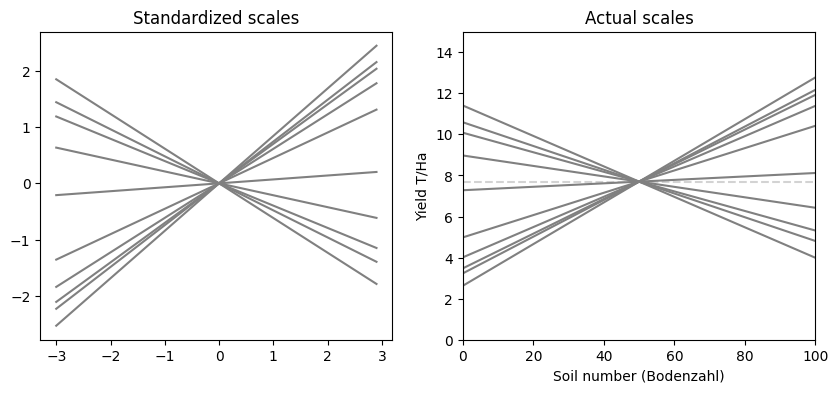

In [27]:
# Generate synthetic data from model
nPriorSamples = 10 # number of prior samples

# Update the random number seed
rng_key, rng_key_ = random.split(rng_key) 

# Change a and b here!
a=0.5 #originally 3
b=1 #originally 3

# Draw sample from model
prior_predictive = Predictive(ourYieldModel, num_samples=nPriorSamples)
prior_samples = prior_predictive(rng_key_,Soil_sd=soil_sd_synthetic,a=a, b=b)

# Use our function to create plots
plot_regression_lines(prior_samples,guessMeanYield,guessStdYield,meanSoilSynthetic,stdSoilSynthetic)

## Reflect on prior knowledge

***
<div class="alert alert-block alert-success">

__Class Task: Compare our prior lines with our regression voting line exercise__

1) Are you happy with the prior prediction lines?

2) Reflect more broadly on what we are doing here. What is our prior expectations in a frequentist econometrics setting?      

</div>

In [ ]:
# in the frequentist, you prior expectation is without constraints, saying that any regression line could be possible.
#You don't state aa or b and so....

# Workflow Step 5: Testing

1) Set a specific effect of soil on yield (i.e. set $\beta$)
2) Run the estimation (i.e. inference step) to check if the model can recover the effect we set in 1)

In [39]:
# "Condition" the model i.e. fix some random variables, here specifically beta
coefTrue = {'beta':1.5}

# Create a Predictive object that with the conditioning value 
condition_model = numpyro.handlers.condition(ourYieldModel, data=coefTrue)
conditioned_predictive = Predictive(condition_model, num_samples=1)
# Generate samples using the conditioned model
a_conditioning = 1
b_conditioning = 1
rng_key, rng_key_ = random.split(rng_key) 
condition_samples = conditioned_predictive(rng_key_,Soil_sd=soil_sd_synthetic,a=a_conditioning, b=b_conditioning)
condition_samples

{'Yield_sd': Array([[ 2.2539907 ,  2.3427687 , -3.5561228 ,  1.428577  ,  0.02435267,
          0.5045409 , -0.78838706, -1.3086836 ,  1.1875913 ,  0.7547103 ,
          1.8812747 ,  2.4144347 , -2.2195983 , -2.846734  ,  0.47640878,
          1.0110611 ,  0.6643276 ,  0.46727723, -1.2483433 , -1.8600975 ,
         -0.30285856, -0.7568454 , -1.5381036 , -0.12155536,  0.14953005,
         -0.2694322 ,  0.9067892 , -2.0294306 , -1.0949692 , -0.85217273,
          2.026427  ,  1.9021113 ,  0.30335784, -2.6121156 ,  1.3033811 ,
          2.2099974 , -0.92748666, -0.41372076, -0.19657344,  0.7647567 ,
         -3.493166  ,  2.1799383 , -0.3446045 , -0.14440095, -0.28097737,
         -0.8183795 ,  0.43990284,  0.20479453,  3.0834439 , -1.1335788 ]],      dtype=float32),
 'beta': Array([1.5], dtype=float32, weak_type=True),
 'sigma': Array([0.9127797], dtype=float32)}

In [40]:
# Get the outcomes variable from the conditioned model
Yield_sd_condition = condition_samples['Yield_sd'][0,:]

In [41]:
# Estimate model using numpyro MCMC

# Specify a, b for prior used in the estimation
a_estimation = 1
b_estimation = 1
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(ourYieldModel)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000, num_chains=2)
mcmc.run(rng_key_, Soil_sd=soil_sd_synthetic, a=a_estimation, b=b_estimation, Yield=Yield_sd_condition)
# why use the second reng_key and not the first?
post_samples = mcmc.get_samples() #i.e., posterior samples
mcmc.print_summary()

/tmp/ipykernel_98/180437228.py:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [00:00<00:00, 5491.74it/s, 7 steps of size 7.37e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      1.36      0.14      1.36      1.14      1.58   1182.22      1.00
     sigma      0.89      0.09      0.89      0.74      1.05   1336.08      1.00

Number of divergences: 0


In [42]:
# Compare estimate of beta with a OLS regression using statsmodels
import statsmodels.api as sm
mod = sm.regression.linear_model.OLS(np.array(Yield_sd_condition), soil_sd_synthetic)    
res = mod.fit()  
print(res.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.687
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              107.6
Date:                Mon, 21 Oct 2024   Prob (F-statistic):                    5.89e-14
Time:                        14:46:03   Log-Likelihood:                         -63.976
No. Observations:                  50   AIC:                                      130.0
Df Residuals:                      49   BIC:                                      131.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [43]:
# Draw more samples from prior for plotting
prior_predictive = Predictive(ourYieldModel, num_samples=1000)
prior_samples = prior_predictive(rng_key_,Soil_sd=soil_sd_synthetic,a=a_estimation, b=b_estimation)
# Add one dimension for num_chains
for key in prior_samples.keys():
    prior_samples[key] = prior_samples[key][None,:]


In [44]:
# Function to plot estimation results
def plot_beta_posterior(prior_samples,post_samples,beta_ref=None, label1='prior', label2='prior'):
    dsPrior = az.convert_to_dataset(prior_samples,group='prior')
    dsPost = az.convert_to_dataset(post_samples,group='posterior',)
    xrr = az.convert_to_inference_data(dsPost)
    xrr.add_groups(prior=dsPrior)
    # Plot posterior
    ax = az.plot_posterior(
        xrr,
        coords={},
        group='posterior',
        label='posterior',
        var_names=['beta'],
        ref_val=(beta_ref),
    )
    # Plot prior
    ax = az.plot_posterior(
        xrr,
        coords={},
        group='prior',
        var_names=['beta'],
        hdi_prob='hide',
        point_estimate=None,
        color='green',
        label='prior',
        ax=ax
    )



In [45]:
# Function to plot estimation results
def plot_beta_posterior(prior_samples,post_samples,beta_ref=None, label1='prior', label2='posterior'):
    dsPrior = az.convert_to_dataset(prior_samples,group='prior')
    dsPost = az.convert_to_dataset(post_samples,group='posterior',)
    xrr = az.convert_to_inference_data(dsPost)
    xrr.add_groups(prior=dsPrior)
    # Plot posterior
    ax = az.plot_posterior(
        xrr,
        coords={},
        group='posterior',
        label=label2,
        var_names=['beta'],
        ref_val=(beta_ref),
    )
    # Plot prior
    ax = az.plot_posterior(
        xrr,
        coords={},
        group='prior',
        var_names=['beta'],
        hdi_prob='hide',
        point_estimate=None,
        color='green',
        label=label1,
        ax=ax
    )



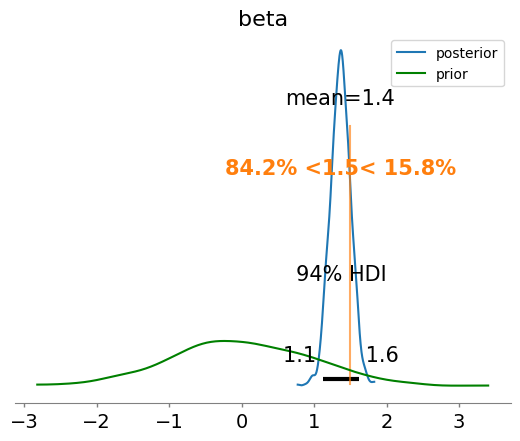

In [46]:
# Create results plot for synthetic data
plot_beta_posterior(prior_samples,post_samples,beta_ref=coefTrue['beta'])

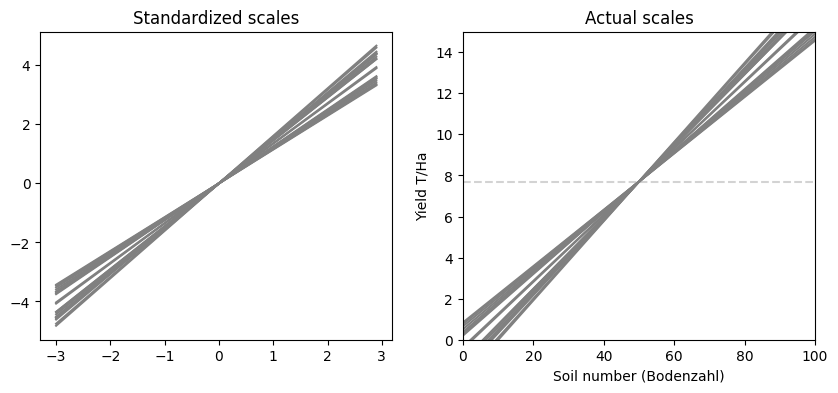

In [47]:
# Use our function to create plots
plot_regression_lines(post_samples,guessMeanYield,guessStdYield,meanSoilSynthetic,stdSoilSynthetic,nLines=20)


## Reflect on posterior regression lines 

***
<div class="alert alert-block alert-success">

__Class Task: Compare the posterior regression lines with the  prior lines__

Do these lines make sense considering how we conditioned the model?

</div>

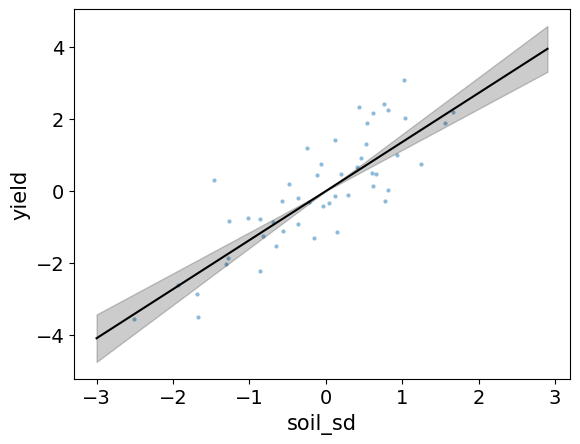

In [48]:
# Plot posterior lines in a different way and add raw data
fig,ax = plt.subplots()
# fading out points to make line and interval more visible
az.plot_pair(
    {'soil_sd':soil_sd_synthetic,'yield':Yield_sd_condition}, scatter_kwargs={"alpha": 0.5},
    ax=ax
)
soil_sd_range = np.arange(-3,3,0.1)
y_pred_mean = np.mean(post_samples['beta'])*soil_sd_range
# plot the MAP line, aka the mean mu for each weight
ax.plot(soil_sd_range, y_pred_mean, "k")

beta_PI = np.percentile(post_samples['beta'], q=np.array([5.5, 94.5]), axis=0)
mu_PI = soil_sd_range[None,:]*beta_PI[:,None]
# plot a shaded region for 89% PI
ax.fill_between(soil_sd_range, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

plt.show()

shape mu: (2000, 60)
shape mu_mean: (60,)
shape mu_HPDI: (2, 60)
shape sim_yield: (2000, 60)


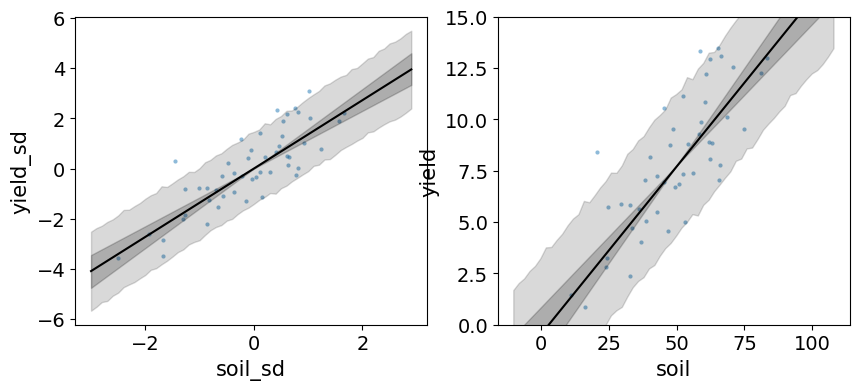

In [49]:
def plotRegressionHPDI(model, samples, soil_sd, yield_sd, soil_sd_range, meanYield,stdYield,meanSoil,stdSoil):
    # For each posterior sample calculate prediction for all observations
    #mu_link = lambda weight: post_samples["a"] + post_samples["b"] * (weight - xbar)
    mu_link = lambda soil_sd: samples["beta"] * soil_sd
    mu = vmap(mu_link)(soil_sd_range).T
    # Calculate mean of prediction across all posterior samples
    mu_mean = jnp.mean(mu, 0)
    # Caluclate HPDI for all prediction across all posterior samples
    mu_HPDI = hpdi(mu, prob=0.89, axis=0)
    print("shape mu:",mu.shape)
    print("shape mu_mean:",mu_mean.shape)
    print("shape mu_HPDI:",mu_HPDI.shape)

    # Use the model to predict outcomes for each posterior sample for a range of soil values
    sim_yield = Predictive(model, samples, return_sites=["Yield_sd"])(
        random.PRNGKey(2), soil_sd_range, None
    )["Yield_sd"]
    print("shape sim_yield:",sim_yield.shape)
    
    # Calculate precentiles for yield predictions across soil range
    yield_PI = jnp.percentile(sim_yield, q=jnp.array([5.5, 94.5]), axis=0)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
    # plot raw data
    # fading out points to make line and interval more visible
    az.plot_pair(
        {'soil_sd':soil_sd,'yield_sd':yield_sd}, scatter_kwargs={"alpha": 0.5},
        ax=ax1
    )
    az.plot_pair(
        {'soil':soil_sd*stdSoil+meanSoil,'yield':yield_sd*stdYield+meanYield}, scatter_kwargs={"alpha": 0.5},
        ax=ax2
    )

    ax2.set_ylim(0,15)
    
    # draw MAP line
    ax1.plot(soil_sd_range, mu_mean, "k")
    ax2.plot(soil_sd_range*stdSoil+meanSoil, mu_mean*stdYield+meanYield, "k")
    
    # draw HPDI region for line
    ax1.fill_between(soil_sd_range, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)
    ax2.fill_between(soil_sd_range*stdSoil+meanSoil, mu_HPDI[0]*stdYield+meanYield, mu_HPDI[1]*stdYield+meanYield, color="k", alpha=0.2)
    
    # draw PI region for simulated soil range
    ax1.fill_between(soil_sd_range, yield_PI[0], yield_PI[1], color="k", alpha=0.15)
    ax2.fill_between(soil_sd_range*stdSoil+meanSoil, yield_PI[0]*stdYield+meanYield, yield_PI[1]*stdYield+meanYield, color="k", alpha=0.15)
    fig.show()
plotRegressionHPDI(ourYieldModel, post_samples, soil_sd_synthetic, Yield_sd_condition, soil_sd_range,
                  guessMeanYield,guessStdYield,meanSoilSynthetic,stdSoilSynthetic)

# Workflow Step 6: Real Data

Afer we made sure that everything is working with synthetic data lets do exactly the same using real data!!

__Steps__

1) Download data that we want to use for estimation
2) Prepare data and select variables
3) Standardize data
4) Run estimation
5) Check prior influence
6) Check estimation results

__1) Download data__

In [ ]:
dfYield = pd.read_csv("https://raw.githubusercontent.com/hstorm/pp_agecon_erae/master/data/yield.csv")
dfYield.head()

In [ ]:
dfYield

__2) Prepare data and select variables__

In [ ]:
plt.hist(dfYield.loc[dfYield['year']==2013,'Winterweizen_bodenzahl']);

In [ ]:
plt.hist(dfYield['Winterweizen_yield']);

In [ ]:
yieldWW = dfYield['Winterweizen_yield']/10 # transfor from dt to t
soil = dfYield['Winterweizen_bodenzahl']
n = yieldWW.shape[0]
print('n',n)
print('Shape yield',yieldWW.shape)
print('Shape soil',soil.shape)

In [ ]:
plt.hist(yieldWW);

__3) Standardize data__

In [ ]:
# 1) Mean of 
meanYieldWW = np.mean(yieldWW)
meanSoil = np.mean(soil)
# 2) standard deviation of: 
stdYield = np.std(yieldWW)
stdSoil = np.std(soil)

yieldWW_sd = jnp.array((yieldWW-meanYieldWW)/stdYield)
soil_sd = jnp.array((soil-meanSoil)/stdSoil)

print("Mean yield",meanYieldWW)
print("Mean soil",meanSoil)
print("Std yield",stdYield)
print("std soil",stdSoil)



__4) Run estimation__
(using exactly the same model from above)

In [ ]:
# Estimate model using numpyro MCMC

# Specify a, b for prior used in the estimation
a_estimation = 1
b_estimation = 1
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(ourYieldModel)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000, num_chains=2)
# Note the only thing we change here compared to what we have above is that we use actuall data here
mcmc.run(rng_key_, Soil_sd=soil_sd, a=a_estimation, b=b_estimation, Yield=yieldWW_sd)
post_samples = mcmc.get_samples()
mcmc.print_summary()

__6) Check estimation results__

In [ ]:
# Draw more samples from prior for plotting
prior_predictive = Predictive(ourYieldModel, num_samples=1000)
prior_samples = prior_predictive(rng_key_,Soil_sd=soil_sd_synthetic,a=a_estimation, b=b_estimation)
# Add one dimension for num_chains
for key in prior_samples.keys():
    prior_samples[key] = prior_samples[key][None,:]
    
# Create results plot for synthetic data
plot_beta_posterior(prior_samples,post_samples)

In [ ]:
# Use our function to create plots
plot_regression_lines(post_samples,meanYieldWW,stdYield,meanSoil,stdSoil,nLines=50)


In [ ]:
# Plot the posterior predictions interval
plotRegressionHPDI(ourYieldModel, post_samples, soil_sd, yieldWW_sd, soil_sd_range,
                  meanYieldWW,stdYield,meanSoil,stdSoil)

__5) Check prior influence__

In [ ]:
# Specify a, b for prior used in the estimation
a_estimation1 = 1
b_estimation1 = 1
a_estimation2 = 0.5
b_estimation2 = 0.5

rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(ourYieldModel)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000, num_chains=2)
# Note the only thing we change here compared to what we have above is that we use actuall data here
mcmc.run(rng_key_, Soil_sd=soil_sd, a=a_estimation1, b=b_estimation1, Yield=yieldWW_sd)
post_samples1 = mcmc.get_samples()
mcmc.run(rng_key_, Soil_sd=soil_sd, a=a_estimation2, b=b_estimation2, Yield=yieldWW_sd)
post_samples2 = mcmc.get_samples()


In [ ]:
# Create results plot for synthetic data
plot_beta_posterior(post_samples1,post_samples2, label1='posterior1', label2='posterior2')